In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pylops
import pyproximal
from scipy.signal import filtfilt, convolve
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')
 
np.random.seed(1)

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## An introduction to proximal solvers for engineers
### Day 1 @ Luna Innovation 
### Instructor: Matteo Ravasi, Assistant Professor - KAUST

## About the Instructor

### Matteo Ravasi, Assistant Professor - KAUST

Career:

- Assistant Professor, King Abdullah University of Science and Technology (KAUST) - 2021-Now
- Research Geophysicist, Statoil/Equinor - 2015-2020
- Ph.D in Geophysics, University of Edinburgh - 2012-2015
- BSc & MSc in Telecommunication Engineering, Politecnico di Milano - 2006-2011

Extra:

- Main developer and mantainer of the [PyLops](http://github.com/pylops) framework
- Amateur photographer
- Inter Milan supporter

## Motivation

Gradient-based optimization:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (nonlinear)}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2 + \alpha ||\mathbf{m}||_2^2 + \beta ||\nabla_x\mathbf{m}||_2^2 + \gamma ||\nabla_z\mathbf{m}||_2^2 \qquad \textrm{L2-regularized (linear)}
$$

## Motivation

Proximal-based optimization:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{||\mathbf{m}||_1} \qquad \textrm{L1-regularized / Sparse inversion}
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{||\mathbf{M}||_*} \qquad \textrm{Low-rank matrix approximation} 
$$

and 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha \color{blue}{TV(\mathbf{m})} \qquad \textrm{TV-regularized inversion} 
$$

and 

$$
\underset{\mathbf{m} \color{blue}{\in C}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2  \qquad \textrm{Constrained inversion}
$$

## Motivation

L1 norm:
    
$$
||\mathbf{m}||_1=\sum_i |m_i|
$$

Nuclear norm:
    
$$
||\mathbf{M}||_*=\sum_i \sigma_i
$$

Total-variation norm:

$$
TV(\mathbf{m})=\sqrt{\partial_x \mathbf{m}^2 + \partial_z \mathbf{m}^2}
$$

What do these functions have in common? **Non-smooth function**

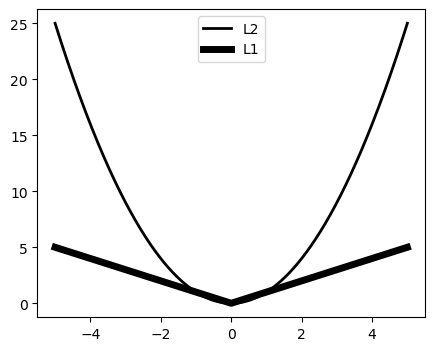

In [3]:
plt.figure(figsize=(5, 4))
x = np.arange(-5, 5.01, 0.01)
plt.plot(x, x**2, 'k', lw=2, label='L2')
plt.plot(x, np.abs(x), 'k', lw=5, label='L1')
plt.legend();

## Notation

The following convention will be used in the rest of the course:

- $\mathbf{m} \in \mathbb{R}^M$: model. Quantity that we are interested to know and we think affects the observed data - human organs, rock properties, temperature, atmosferic pressure, ...
- $\mathbf{d} \in \mathbb{R}^N$: observed data. Quantity that we can physicially measure - CT scan, seismic data, production data, precipitation, ...
- $\mathcal{G}/\mathbf{G} \in \mathbb{R}^{M \rightarrow N}$: nonlinear/linear modelling operator. Set of equations that we think can explain the data by nonlinear/linear combination of model parameters - wave equation, Navier-stoke (or any other PDE)/Radon transform, blurring filter, seismic convolutional model...

## Denoising

We want to reconstruct a blocky 1D signal from noisy measuments:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla^2 \mathbf{m}||_2^2
$$

or 

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{m}||_2^2 + \alpha ||\nabla\mathbf{m}||_1
$$

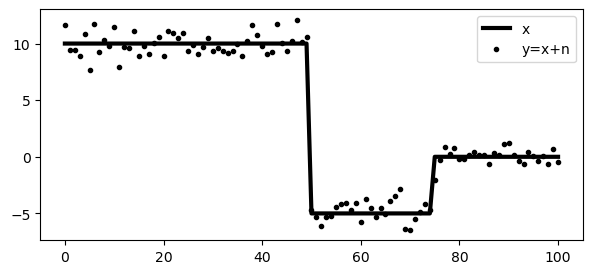

In [4]:
nx = 101
x = np.zeros(nx)
x[: nx // 2] = 10
x[nx // 2 : 3 * nx // 4] = -5

Iop = pylops.Identity(nx)
n = np.random.normal(0, 1, nx)
y = Iop * x + n

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.legend();

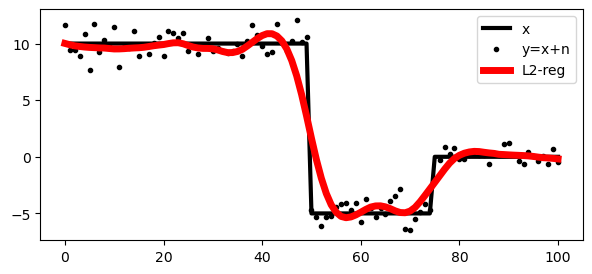

In [5]:
D2op = pylops.SecondDerivative(nx, edge=True)
alpha = 1e1

xinv = pylops.optimization.leastsquares.regularized_inversion(
    Iop, y, [D2op], epsRs=[alpha], **dict(iter_lim=30))[0]

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.legend();

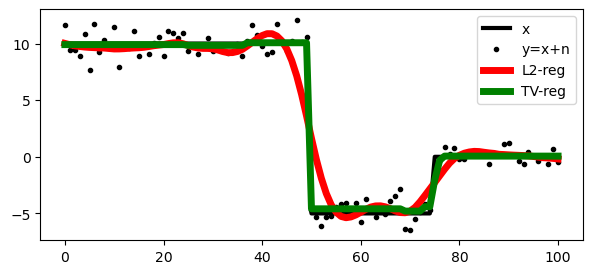

In [6]:
D2op = pylops.FirstDerivative(nx, edge=True, kind='backward')
g = pyproximal.L1(2.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1. / L
mu = tau 
xtv = pyproximal.optimization.primal.ADMML2 \
        (g, Iop, y, D2op, np.zeros_like(x),
         tau, niter=500, show=False, iter_lim=100)[0]

plt.figure(figsize=(7, 3))
plt.plot(x, "k", lw=3, label="x")
plt.plot(y, ".k", label="y=x+n")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.plot(xtv, "g", lw=5, label="TV-reg")
plt.legend();

## The anatomy of a proximal solver

In this course, we will always start from the following general optimization problem:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} f(\mathbf{m}) + g(\mathbf{Lm})
$$

where:

- $f(\mathbf{m})$: main term (i.e., data misfit term). Usually smooth (i.e., differentiable), in some cases can be non-smooth (e.g., indicator function).
- $g(\mathbf{Lm})$: secondary term (i.e., regularization term). Usually non-smooth but *proximable*. It can also be a sum of multiple functions $g(\mathbf{m})=\sum_i g_i(\mathbf{Lm})$.
- $\mathbf{L} \in \mathbb{R}^{M \rightarrow K}$: linear operator.

## The anatomy of a proximal solver

Any proximal solver comprises of the following operations:

- linear operator (forward and adjoint): $\mathbf{L}$ and $\mathbf{L}^H$
- gradient or linear/nonlinear solve: $\partial f$ or ${\text{argmin}} f(\mathbf{m}) + ...$
- proximal operator: $prox_g$ (and $prox_f$)
- simple operations on vectors: dot-products, scalar-vector products, etc.

A software that implements proximal solvers should handle these 4 components.

## The anatomy of a proximal solver (in Python)

Any proximal solver comprises of the following operations:

- linear operator (forward and adjoint): $\mathbf{L}$ and $\mathbf{L}^H$ $\rightarrow \color{blue}{\text{PyLops}}$
- gradient or linear/nonlinear solve: $\partial f$ or ${\text{argmin}} f(\mathbf{m}) + ...$ $\rightarrow \color{blue}{\text{PyProximal}}$
- proximal operator: $prox_g$ (and $prox_f$) $\rightarrow \color{blue}{\text{PyProximal}}$
- simple operations on vectors: dot-products, scalar-vector products, etc. $\rightarrow \color{blue}{\text{NumPy}}$

A software that implements proximal solvers should handle these 4 components.

## A prelude of what is about to come...

Given:
    
$$
\underset{\mathbf{m}} {\mathrm{argmin}} f(\mathbf{m}) + g(\mathbf{Lm})
$$

we can use:

- gradient-based optimizers if $f$ (and $g$) are differentiable;
- proximal point if $f$ is proximable and $g=0$;
- proximal gradient if $f$ is differentiable, $g$ is proximable, and $\mathbf{L}=\mathbf{I}$;
- HQS/ADMM if $f$ and $g$ are proximable and $\mathbf{L}=\mathbf{I}$;
- ADMM if $f=\frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2$, $g$ is proximable, and $\mathbf{L}$ is any linear operator;
- Chambolle-Pock Primal Dual if $f$ and $g$ are proximable and $\mathbf{L}$ is any linear operator.

## A prelude of what is about to come...

<img src="../figs/ProximalDecisionTree.png" width="700" align="center">

## Gradient-based optimization

Let's define the general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is a **smooth** convex function (e.g. L2 norm).

This can be solved via the **Gradient Descent** algorithm:

$$
\mathbf{m}_{k+1} = \mathbf{m}_k - \alpha \nabla f(\mathbf{m}_k)
$$

where $\alpha$ is the step-size.

We can rewrite this as a Fixed-Point algorithm defining $\mathcal{T}(\mathbf{m})=(I- \alpha \nabla f)(\mathbf{m})$:

$$
\mathbf{m}_{k+1} = \mathcal{T}(\mathbf{m}_k)
$$

and when the fixed-point $\mathbf{m}_*$ is reached we have found the solution!

## Gradient-based optimization

Two special cases commonly used in inverse problem theory are:

- nonlinear data-fitting term: $f_{nl}=\frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2$
- linear data fitting term: $f_{l}=\frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2$

whose derivatives are:

$$
\text{nonlinear:} \nabla f_{nl} (\mathbf{m}) = - \mathbf{G}^H (\mathbf{d} - \mathcal{G}(\mathbf{m})) \quad (\mathbf{G} \text{ is the Jacobian of }  \mathcal{G}(\mathbf{m}))
$$
$$
\text{linear:} \nabla f_{l}(\mathbf{m}) = - \mathbf{G}^H (\mathbf{d} - \mathbf{G}\mathbf{m})
$$

## Gradient-based optimization - linear

For linear problems of the kind $\mathbf{d} = \mathbf{G}\mathbf{m}$:

$$
\text{square:} \hat{\mathbf{m}} = \mathbf{G}^{-1} \mathbf{d}
$$
$$
\text{overdetermined} (f=\frac{1}{2} ||\mathbf{d} - \mathbf{G}\mathbf{m}||_2^2): \hat{\mathbf{m}} = (\mathbf{G}^H\mathbf{G})^{-1} \mathbf{G}^H \mathbf{d}
$$
$$
\text{underdetermined} (f=\frac{1}{2} ||\mathbf{m}||_2^2 s.t. \mathbf{d} = \mathbf{G}\mathbf{m}): \hat{\mathbf{m}} = \mathbf{G}^H (\mathbf{G}\mathbf{G}^H)^{-1}  \mathbf{d}
$$

To obtain $\mathbf{G}^{-1}/ (\mathbf{G}^H\mathbf{G})^{-1} / (\mathbf{G}\mathbf{G}^H)^{-1}$:
- direct solvers: LU, QR, ..
- iterative solvers: CG, LSQR, ...

## Dense matrices vs linear operators

For iterative solvers, one must simply know how to compute $\mathbf{G}\mathbf{x}$ (forward) and $\mathbf{G}^H\mathbf{y}$ (adjoint) --> useful when $\mathbf{G}$ is too large to be inverted and/or stored.

- Dense matrix: a place in computer memory where to store $N \times M$ elements of $\mathbf{G}$
- Linear operator: a piece of computer code that can perform forward and adjoint operations without the need to store an explicit matrix

**Dot-test** : mathematical equality used to verify correctness of forward/adjoint pair

$$(\mathbf{G}\cdot \mathbf{u})^H\mathbf{v} = \mathbf{u}^H(\mathbf{G}^H \cdot \mathbf{v})$$

## Dense matrices vs linear operators

First derivative (forward):

$$
\mathbf{D} = \begin{bmatrix} -1 & 1 & ... & 0 & 0 \\ -0.5 & 0 & 0.5 & ... & 0 \\ ... \\ 0 & 0 & ... & -1 & 1 \\ \end{bmatrix} 
$$

```python
def _matvec(x):
    y = np.zeros(x.size, self.dtype)
    y[1:-1] = (0.5 * x[2:] - 0.5 * x[0:-2]) / self.sampling
    # edges
    y[0] = (x[1] - x[0]) / self.sampling
    y[-1] = (x[-1] - x[-2]) / self.sampling
    return y
```

## Dense matrices vs linear operators

First derivative (adjoint):

$$
\mathbf{D}^H = \begin{bmatrix} -1 & -0.5 & ... & 0 & 0 \\ 1 & 0 & -0.5 & ... & 0 \\ ... \\ 0 & 0 & ... & -0.5 & 1 \\ \end{bmatrix}
$$

```python
def _rmatvec(x):
    y = np.zeros(x.size, self.dtype)
    y[0:-2] -= (0.5 * x[1:-1]) / self.sampling
    y[2:] += (0.5 * x[1:-1]) / self.sampling
    # edges
    y[0] -= x[0] / self.sampling
    y[1] += x[0] / self.sampling
    y[-2] -= x[-1] / self.sampling
    y[-1] += x[-1] / self.sampling
    return y
```

## Dense matrices vs linear operators

Time to practice: [EX1](https://github.com/mrava87/ProximalTeaching/blob/main/examples/FFTLinOp.ipynb)

## Proximal operator

$$
prox_{\tau f} (\mathbf{v}) = (I+ \tau \partial f)^{-1}(\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m}) + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

<img src="../figs/ProximalOp.png" width="500" align="center">

Source: Parikh N., Proximal Algorithms.

## Proximal operator

To understand $(I+ \tau \partial f)^{-1}(\mathbf{v})$, we can simply write the (sub)gradient of the objective function:

$$
0 \in \partial f(\mathbf{m}) + \frac{1}{\tau}(\mathbf{m}-\mathbf{v})
$$
$$
\mathbf{v} = \tau \partial f(\mathbf{m}) + \mathbf{m} =  (I+ \tau \partial f)(\mathbf{m})
$$
$$
\mathbf{m} = (I+ \tau \partial f)^{-1}(\mathbf{v})
$$

## Proximal operator

An inverse problem at every step of the iterative scheme... bahhh!!

Luckily many proximal operators have **closed-form** solution:

$$
\text{Squared L2:} \;
prox_{\tau ||\cdot||_2^2} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_2^2 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = \frac{\mathbf{v}}{1+\tau}
$$

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = soft(\mathbf{v}, \tau) \quad \text{(soft-thresholding)}
$$  

$$
\text{Box constraint:} \;prox_{Box_{[l, u]}} (\mathbf{v})  = \underset{\mathbf{m} \in Box} {\mathrm{argmin}} \;  \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2 = min\{ max \{\mathbf{v}, l\}, u \}
$$ 

See Parikh N., Proximal Algorithms for an extensive list of Proximal operators.

## Proximal operator

Let's look at one (just one, I promise) derivation:

$$
\text{L1:} \;prox_{\tau ||\cdot||_1} (\mathbf{v})  = \underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1 + \frac{1}{2\tau}||\mathbf{m}-\mathbf{v}||_2^2
$$

First, let's realize the problem is separable with respect to both $\mathbf{v}$ and $\mathbf{m}$. For $M=3$:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; |m_1| + |m_2| + |m_3| + \frac{1}{2\tau}((m_1-v_1)^2 + (m_2-v_2)^2 + (m_3-v_3)^2)
$$

so for any $i=1,2,3$:

$$
\underset{m_i} {\mathrm{argmin}} \; |m_i| + \frac{1}{2\tau}(m_i-v_i)^2 = \underset{m_i} {\mathrm{argmin}} \; \tau|m_i| + \frac{1}{2}(m_i-v_i)^2 = \mathcal{l}(m_i)
$$

## Proximal operator

We observe that $m_i$ can be either negative, zero, or positive and we treat the three cases separately:

$m_i > 0$: $\partial \mathcal{l}(m_i) / \partial m_i = \tau + m_i-v_i  = 0 \rightarrow m_i = v_i - \tau \;  (v_i > \tau)$

$m_i < 0$: $\partial \mathcal{l}(m_i) / \partial m_i = - \tau + m_i-v_i  = 0 \rightarrow m_i = v_i + \tau \;  (v_i < -\tau)$

$m_i = 0$: $\partial \mathcal|m_i| / \partial m_i \in [-1,1] \rightarrow m_i = 0 \; (-\tau \ge v_i \ge \tau)$

One of many sources: https://www.youtube.com/watch?v=LABiFM79W6M

In [7]:
import pyproximal

# L2
l2sq = pyproximal.L2(sigma=1.)

x = np.arange(3)
print('L2sq: %.2f' % l2sq(x), ', L2sq prox', l2sq.prox(x, 2.))

# L1
l1 = pyproximal.L1(sigma=1.)

x = np.arange(3)
print('L1: %.2f' % l1(x), ', L1 prox', l1.prox(x, 1.3))

L2sq: 2.50 , L2sq prox [0.         0.33333333 0.66666667]
L1: 3.00 , L1 prox [0.  0.  0.7]


## Proximal operator

Other important proximal operators are:

$$
\text{Affine Set:} \;
prox_{\mathbf{Gx}=\mathbf{d}} (\mathbf{v}) = \mathbf{v} - \mathbf{G}^H(\mathbf{G}\mathbf{G}^H)^{-1}(\mathbf{Gv}-\mathbf{d})
$$

$$
\text{L2 Ball:} \;
prox_{\tau ||\cdot - \mathbf{c}||_2 \leq r} (\mathbf{v}) = \mathbf{c} + \frac{r}{max\{ ||\mathbf{v} - \mathbf{c}||_2, r\}}(\mathbf{v} - \mathbf{c})
$$

$$
\text{L0:} \;prox_{\tau ||\cdot||_0} (\mathbf{v})  = hard(\mathbf{v}, \tau) \quad \text{(hard-thresholding)}
$$  

$$ 
\text{Nuclear Norm:} \;prox_{\tau \sigma \|\cdot\|_*}(\mathbf{X}) = \mathbf{U} diag \{ prox_{\tau \sigma \|\cdot\|_1}(\boldsymbol\lambda) \} \mathbf{V}^H
$$

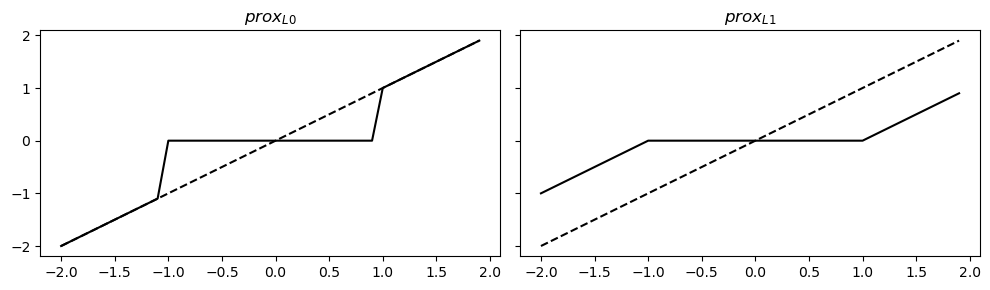

In [8]:
# LO and L1
l0 = pyproximal.L0()
l1 = pyproximal.L1()

x = np.arange(-2, 2, 0.1)
xp0, xp1 = l0.prox(x, 1.), l1.prox(x, 1.)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 3))
axs[0].plot(x, xp0, 'k'), axs[0].plot(x, x, '--k')
axs[0].set_title(r'$prox_{L0}$')
axs[1].plot(x, xp1, 'k'), axs[1].plot(x, x, '--k')
axs[1].set_title(r'$prox_{L1}$')
plt.tight_layout();

## Proximal operator

Finally, let's consider a few useful properties of the proximal operator:

$$
\text{Separable function: } f(\mathbf{x})=\sum_{i=1}^{M} f_i(x_i), \; prox_{\tau f} (\mathbf{v}) = [prox_{\tau f_1} (v_1),prox_{\tau f_2} (v_2), ..., prox_{\tau f_M} (v_M)]^T
$$
$$
\text{Pre-composition: } g(\mathbf{x})=f(a \mathbf{x} + \mathbf{b})  \; (a\ne 0) \;\; prox_{\tau g} (\mathbf{v}) = \frac{1}{a} (prox_{a^2 \tau f} (a \mathbf{v} + \mathbf{b}) - \mathbf{b})
$$
$$
\text{Post-composition: } g(\mathbf{x})=a f(\mathbf{x}) + b \; (a>0) \;\; prox_{\tau g} (\mathbf{v}) = prox_{a \tau f} (\mathbf{v})
$$
$$
\text{Affine addition: } prox_{\tau (f(\mathbf{x}) + \mathbf{a}^T \mathbf{x}) + b} (\mathbf{v})  = prox_{\tau f} (\mathbf{v} - \tau \mathbf{a})
$$

## Proximal operator

Why are they useful?

- Separable function: see derivation of $L_1$ norm

- Pre-composition: e.g., $TV(\mathbf{x}+ \mathbf{b})$

- Post-composition: allows scaling any norm by a factor

- Affine addition: extending proximal operators to other distances (e.g., Bregman)

## Proximal operator

<img src="../figs/ProxOperator.png" width="500" align="center">

## Proximal Point

Let's define our first special case:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; f(\mathbf{m})
$$

where $f$ is now a **non-smooth** convex function (e.g., L1 norm) and $g=0$.

This can be solved via the **Proximal Point** algorithm:

$$
\mathbf{m}_{k+1} = prox_{\tau f} (\mathbf{m}_k) 
$$

Let's see how this works with a simple example:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; ||\mathbf{m}||_1
$$

In [9]:
def callback(x):
    xhist.append(x)

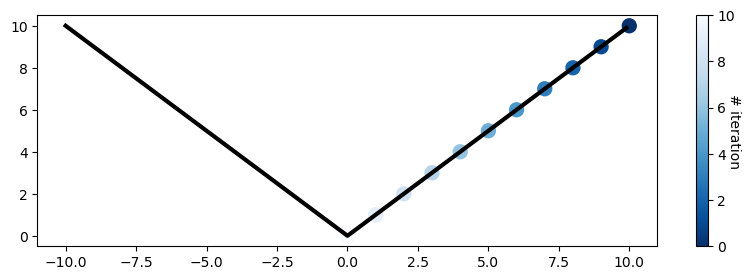

In [10]:
f = pyproximal.L1()
x0 = np.array([10,])
tau = 1.

xhist = [x0, ]
x = pyproximal.optimization.primal.ProximalPoint(f, x0, tau, niter=20, 
                                                 callback=lambda x: callback(x))

plt.figure(figsize=(10, 3))
plt.plot(np.arange(-10, 10, 0.1), np.abs(np.arange(-10, 10, 0.1)), "k", lw=3, label="x")
plt.scatter(xhist, np.abs(xhist), c=np.arange(21), s=100, cmap='Blues_r', vmin=0, vmax=10);
cbar = plt.colorbar()
cbar.ax.set_ylabel('# iteration', rotation=270);

## Proximal Gradient

Let's consider now a second more general case

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) + g(\mathbf{m})
$$

where $f$ is a smooth function (e.g., squared L2 norm) and $g$ is possibly non-smooth, convex function (e.g. L1 norm):

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2 + \alpha ||\mathbf{m}||_1
$$

## Proximal Gradient

A smart way of solving this general problem is to use the **Forward-Backward splitting** algorithm.

Derivation:

$$
0 \in \nabla f(\mathbf{m}) + \partial g(\mathbf{m})
$$
$$
0 \in \mathbf{m}/\tau - \mathbf{m}/\tau + \nabla f(\mathbf{m}) + \partial g(\mathbf{m})
$$
$$
(I-\tau \nabla f)(\mathbf{m}) \in (I+\tau \partial g)(\mathbf{m})
$$
$$
\mathbf{m}_* = (I+\tau \partial g)^{-1} (I-\tau \nabla f)(\mathbf{m}_*)
$$

Algorithm: 

$$
\mathbf{m}_{k+1} = prox_{\tau_k g} (\mathbf{m}_k - \tau_k \nabla f(\mathbf{m}_k))\\
$$

where $\tau_k \in (0, 1/L]$ with $L$ being the Lipschitz constant of $\nabla f$.

## Proximal Gradient

How to estimate $\tau_k$:

1. Compute the Lipschitz constant of $\nabla f$ (i.e. max eigenvalue of the Hessian of $f$). Ex:

$$
f(\mathbf{m}) = \frac{1}{2} ||\mathbf{d} - \mathcal{G}(\mathbf{m})||_2^2
$$
$$
\nabla f = - \mathbf{G}^H ( \mathbf{d} - \mathcal{G}(\mathbf{m}))
$$
$$
\nabla (\nabla f) = \mathbf{G}^H \mathbf{G}
$$
$$
L = \lambda_{max} (\mathbf{G}^H \mathbf{G}) 
$$

## Proximal Gradient

How to estimate $\tau_k$:

2. Use back-tracking (Beck and Teboulle, 2010):

$$
\begin{aligned}
        &start: \; \tau = \tau_{k-1} &\\
        &repeat \; \mathbf{z} = prox_{\tau g}(\mathbf{m}_k -
        \tau \nabla f(\mathbf{m}_k)), \tau = \beta \tau \quad if \;
        f(\mathbf{z}) \leq \tilde{f}_\tau(\mathbf{z}, \mathbf{m}_k) \\
        &end: \;\tau_k = \tau, \quad \mathbf{m}_{k+1} = \mathbf{z} &\\
        \end{aligned}
$$

where $\tilde{f}_\tau(\mathbf{x}, \mathbf{y}) = f(\mathbf{y}) + \nabla f(\mathbf{y})^T (\mathbf{x} - \mathbf{y}) + 1/(2\tau)||\mathbf{x} - \mathbf{y}||_2^2$.

## Proximal Gradient

You may recognize the famous ISTA algorithms here!

When $f=\frac{1}{2} ||\mathbf{d} - \mathbf{Gm}||_2^2$ and $g=||\mathbf{m}||_1$, we have:

$$
\mathbf{m}_{k+1} = prox_{||\cdot||_1} (\mathbf{m}_k - \tau_k \mathbf{G}^H(\mathbf{G}\mathbf{m}_k-\mathbf{d}))\\
$$


## Proximal Gradient

ISTA was first invented by Ingrid Daubechies (the mother of Wavelets) in 2008...

<img src="../figs/ISTA.png" width="500" align="center">

...only much later it was realized that this is a special case of the Proximal Gradient solver.

## Accelerated Proximal Gradient

To improve the converge speed from $O(1/k)$ to $O(1/k^2$), acceleration can be added:

$$
\mathbf{m}_{k+1} = prox_{\tau_k g}(\mathbf{y}_k - \tau_k \nabla f(\mathbf{y}_k))
$$
$$
\mathbf{y}_{k+1} = \mathbf{m}_{k+1} + \omega_k
        (\mathbf{m}_{k+1} - \mathbf{m}_k)
$$

where $\omega_k=k / (k + 3)$ (Vandenberghe, 2010) or $\omega_k = (t_{k-1}-1)/t_k$ with $t_k = (1 + \sqrt{1+4t_{k-1}^{2}}) / 2$ (Beck and Teboulle, 2009).

## Spiky deconvolution

Let's consider an example that can be solved with the Proximal Gradient algorithm:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad \frac{1}{2} ||\mathbf{d} - \mathbf{Wm}||_2^2 + \alpha ||\mathbf{m}||_1
$$

where $\mathbf{d}$ is a band-limited signal and $\mathbf{W}$ is the convolution operator with a prescribed wavelet.

In [11]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

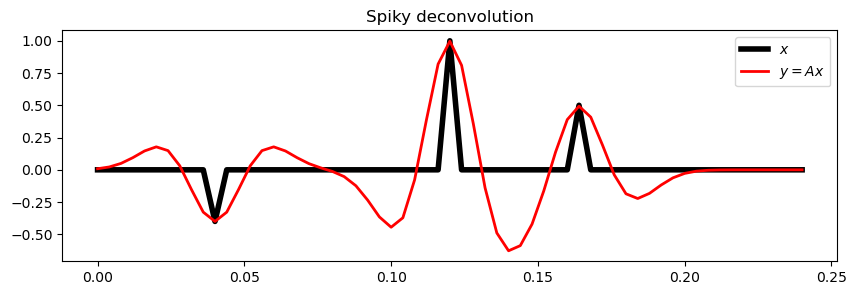

In [12]:
nt, dt = 61, 0.004
t, x = np.arange(nt) * dt, np.zeros(nt)
x[10], x[int(nt / 2)], x[nt - 20] = -0.4, 1, 0.5

h, th, hcenter = pylops.utils.wavelets.ricker(t[:21], f0=20)
Wop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, 
                                         dtype="float32")
y = Wop * x

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, y, "r", lw=2, label=r"$y=Ax$")
ax.set_title("Spiky deconvolution")
ax.legend();

In [13]:
# Least-squares
xls = Wop / y

# L1-regularized
l1 = pyproximal.L1()
l2 = pyproximal.L2(Op=Wop, b=y)
L = np.abs((Wop.H * Wop).eigs(1)[0])
tau = 0.95 / L
eps = 1e-1
niter = 1000

xista_err, xfista_err = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xista_err))
xfista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=niter, 
                callback=lambda xest: callback(xest, x, xfista_err))

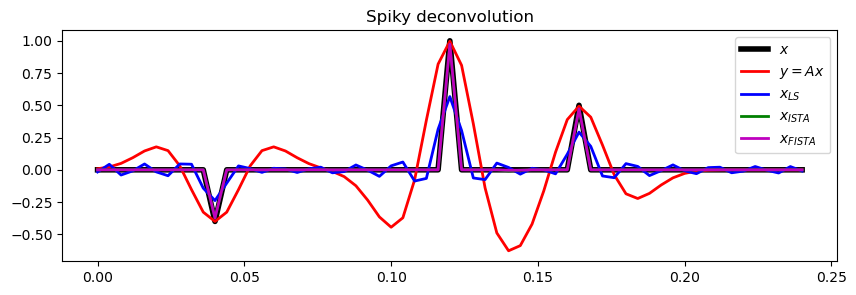

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, y, "r", lw=2, label=r"$y=Ax$")
ax.plot(t, xls, "b", lw=2, label=r"$x_{LS}$")
ax.plot(t, xista, "g", lw=2, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "m", lw=2, label=r"$x_{FISTA}$")
ax.set_title("Spiky deconvolution")
ax.legend();

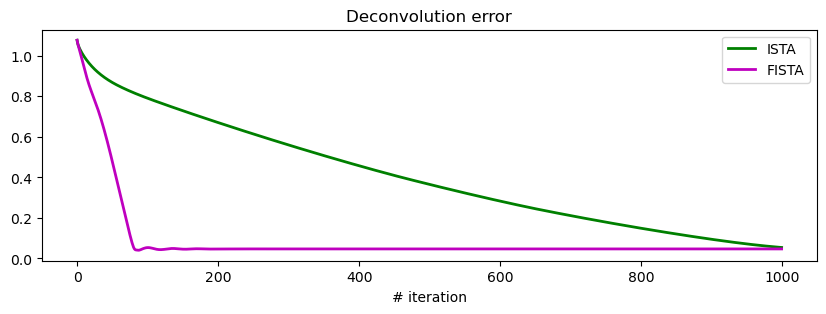

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xista_err, "g", lw=2, label="ISTA")
ax.plot(xfista_err, "m", lw=2, label="FISTA")
ax.set_title("Deconvolution error")
ax.set_xlabel('# iteration')
ax.legend();